# Training differentially private pipelines

We start by importing the required libraries and modules and collecting the data that we need from the [Adult dataset](https://archive.ics.uci.edu/ml/datasets/adult).

In [1]:
! pip install diffprivlib

In [2]:
import numpy as np
import sklearn as sk
from sklearn.pipeline import Pipeline
import pandas as pd
from diffprivlib import models

In [3]:
df=pd.read_csv('train.csv')
df1=pd.read_csv('test.csv')

In [4]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
df1.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,salary
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [6]:
X_train= pd.read_csv('train.csv',usecols=[0,4,10,11,12])
y_train = pd.read_csv('train.csv',usecols=[14])
                        

In [7]:
list_min=[]
list_max=[]

for i in range (0,X_train.shape[1]):
    list_min.append(min(X_train.iloc[:,i].values))
    list_max.append(max(X_train.iloc[:,i].values))


In [8]:
list_min

[17, 1, 0, 0, 1]

In [9]:
list_max

[90, 16, 99999, 4356, 99]

In [10]:
from numpy import inf
from numpy import array
from numpy.linalg import norm

In [11]:
X_train

,age,education-num,capital-gain,capital-loss,hours-per-week
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40
3,53,7,0,0,40
4,28,13,0,0,40
...,...,...,...,...,...
32556,27,12,0,0,38
32557,40,9,0,0,40
32558,58,9,0,0,40
32559,22,9,0,0,20


In [12]:
l2=[]
n=np.asarray(X_train)
for i in range (0,X_train.shape[0]):
    l2.append(norm(n[i,:],inf))
    #print(X[i,:])
    #print(l2)
    #print("\n")
#print(l2)
#print(min(l2))
#print(n)

In [13]:
X_train=X_train.iloc[:,:].values
y_train=y_train.iloc[:,:].values.ravel()

In [14]:
X_train

array([[   39,    13,  2174,     0,    40],
       [   50,    13,     0,     0,    13],
       [   38,     9,     0,     0,    40],
       ...,
       [   58,     9,     0,     0,    40],
       [   22,     9,     0,     0,    20],
       [   52,     9, 15024,     0,    40]], dtype=int64)

In [15]:
y_train

array([' <=50K', ' <=50K', ' <=50K', ..., ' <=50K', ' <=50K', ' >50K'],
      dtype=object)

In [16]:
X_test= pd.read_csv('test.csv',usecols=[0,4,10,11,12])
y_test = pd.read_csv('test.csv',usecols=[14])

In [17]:
list_min1=[]
list_max1=[]

for i in range (0,X_test.shape[1]):
    list_min1.append(min(X_test.iloc[:,i].values))
    list_max1.append(max(X_test.iloc[:,i].values))


In [18]:
list_min1

[17, 1, 0, 0, 1]

In [19]:
list_max1

[90, 16, 99999, 3770, 99]

In [20]:
y_test['salary'] = y_test['salary'].str.replace('.','',regex=True)

In [21]:
X_test=X_test.iloc[:,:].values
y_test=y_test.iloc[:,:].values.ravel()

In [22]:
X_test

array([[  25,    7,    0,    0,   40],
       [  38,    9,    0,    0,   50],
       [  28,   12,    0,    0,   40],
       ...,
       [  38,   13,    0,    0,   50],
       [  44,   13, 5455,    0,   40],
       [  35,   13,    0,    0,   60]], dtype=int64)

In [23]:
y_test

array([' <=50K', ' <=50K', ' >50K', ..., ' <=50K', ' <=50K', ' >50K'],
      dtype=object)

## Pipeline with no privacy

To begin, let's train and test a scikit-learn pipeline without any privacy guarantees. We first use `StandardScaler` to normalise the data to zero mean and unit variance, then use `PCA` to reduce the dimensionality of the system, and then use `LogisticRegression` as a classifier.

In [24]:
pipe = Pipeline([
    ('scaler', sk.preprocessing.StandardScaler()),
    ('pca', sk.decomposition.PCA(2)),
    ('lr', sk.linear_model.LogisticRegression(solver="lbfgs"))
])

We now train the model, and save the test accuracy as a baseline.

In [25]:
pipe.fit(X_train, y_train)
baseline = pipe.score(X_test, y_test)
print("Non-private test accuracy: %.2f%%" % (baseline * 100))

Non-private test accuracy: 80.30%


## Differentially private pipeline

Using `diffprivlib`, we can now train a differentially private pipeline. We use the same components as in our pipeline above, but with each component satisfying differential privacy. We decide on the `bounds` and `data_norm` parameters by trial and error for this example. In practice, these hyperparameters should be chosen using non-sensitive data, i.e. from metadata provided by the data owner.

In [26]:
dp_pipe = Pipeline([
    ('scaler', models.StandardScaler(bounds=([17, 1, 0, 0, 1], [90, 16, 99999, 4356, 99]))),
    ('pca', models.PCA(2, data_norm=17, centered=True)),
    ('lr', models.LogisticRegression(data_norm=17))
])

dp_pipe.fit(X_train, y_train)
print("Differentially private pipeline accuracy (epsilon=1): %.2f%%" % (dp_pipe.score(X_test, y_test) * 100))

Differentially private pipeline accuracy (epsilon=1): 80.97%


Let's now train the pipeline across a range of epsilons.

In [31]:
epsilons = np.logspace(-6, 6, 100)
pipe_accuracy = []

for epsilon in epsilons:
    _eps = epsilon / 3
    dp_pipe.set_params(scaler__epsilon=_eps, pca__epsilon=_eps, lr__epsilon=_eps)
    
    dp_pipe.fit(X_train, y_train)
    pipe_accuracy.append(dp_pipe.score(X_test, y_test))

Let's save the results so they can be used later.

In [32]:
import pickle

pickle.dump((epsilons, baseline, pipe_accuracy), open("pipeline_accuracy_500.p", "wb" ) )

## Results

We can now plot the results, showing that non-private accuracy is matched from approximately `epsilon = 0.1`.

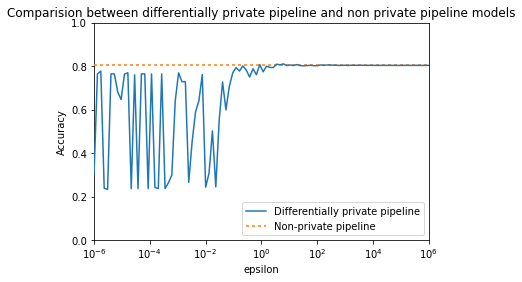

In [33]:
import matplotlib.pyplot as plt
import pickle

epsilons, baseline, pipe_accuracy = pickle.load(open("pipeline_accuracy_500.p", "rb"))

plt.semilogx(epsilons, pipe_accuracy, label="Differentially private pipeline", zorder=10)
plt.plot(epsilons, np.ones_like(epsilons) * baseline, dashes=[2,2], label="Non-private pipeline", zorder=5)
plt.title("Comparision between differentially private pipeline and non private pipeline models")
plt.xlabel("epsilon")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xlim(epsilons[0], epsilons[-1])
plt.legend(loc=4)
plt.show()